# Iceberg Classifier

This project aims to identify iceberg in images that were taken from satellites. The details of this project is provided in different files. Please check _proposal.pdf_ and _report.pdf_.  
  
### Problem Statement
Drifting icebergs are one kind of threat to navigation and activities in offshore areas. It can do serious damage to passing ships. Many companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in harsh weather conditions, the only way is to monitor using satellite. Still, the data has to be  processed manually in order to differentiate icebergs from other objects like a ship. It is a very tedious job to classify icebergs using satellite signals. To solve this problem machine learning can be used. The satellite collects data as an image and the objective is to create an image classifier that can find icebergs in images. A CNN can be used in this case as CNN’s are very good at classifying images. The CNN model will take an image as an input and look for icebergs in that image. The output will be a number between 0 and 1 which will prepresent the probability that the image contains an iceberg.

### Solution Statement
In order to solve the problem described above, we will use Deep Learning with a Convolutional Neural Network to create an image classifier. We will train the CNN with the training data so that it can correctly identify iceberg from other objects. The final model will take an image as an input and output a number between 0 and 1 predicting the probability that the image contains an iceberg. The feature inc_angle has a lot of missing values. As a result, it would not be a good idea to use this as a feature.

## Analysis
### Datasets
Download both train and test data from [this Kaggle competition link](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/data).
### Data Exploration


In [9]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# load train data
df_train = pd.read_json("../input/train.json")

# load test data
df_test = pd.read_json("../input/test.json")

# display datasets
display(df_train.head())
display(df_test.head())

band_1    ...     is_iceberg
0  [-27.878360999999998, -27.15416, -28.668615, -...    ...              0
1  [-12.242375, -14.920304999999999, -14.920363, ...    ...              0
2  [-24.603676, -24.603714, -24.871029, -23.15277...    ...              1
3  [-22.454607, -23.082819, -23.998013, -23.99805...    ...              0
4  [-26.006956, -23.164886, -23.164886, -26.89116...    ...              0

[5 rows x 5 columns]

band_1    ...      inc_angle
0  [-15.863251, -15.201077, -17.887735, -19.17248...    ...      34.966400
1  [-26.058969497680664, -26.058969497680664, -26...    ...      32.615072
2  [-14.14109992980957, -15.064241409301758, -17....    ...      37.505433
3  [-12.167478, -13.706167, -16.54837, -13.572674...    ...      34.473900
4  [-23.37459373474121, -26.02718162536621, -28.1...    ...      43.918874

[5 rows x 4 columns]

In [10]:
# print statistics about the dataset
# train data
print('There are total %d images each with 4 features in train dataset.' % df_train.shape[0])

# test data
print('There are total %d images each with 4 features in test dataset.' % df_test.shape[0])

# check for null values
print('Total number of missing values in train dataset is: %d '% df_train.isnull().sum().sum()) 

# check for null values
print('Total number of missing values in test dataset is: %d '% df_test.isnull().sum().sum()) 

print("\nHowever, according to the dataset description 'inc_angle' has some missing values labeled as 'na'")

# check for null values
print('Total number of missing "inc_angle" in train dataset is: %d \n'% len(df_train.loc[df_train['inc_angle'] == "na"])) 

# number of pixels
print('Each iamge has total %d number of pixels in band_1.'% len(df_train['band_1'][0])) 
print('Each iamge has total %d number of pixels in band_2.'% len(df_train['band_2'][0])) 

There are total 1604 images each with 4 features in train dataset.
There are total 8424 images each with 4 features in test dataset.
Total number of missing values in train dataset is: 0 
Total number of missing values in test dataset is: 0 

However, according to the dataset description 'inc_angle' has some missing values labeled as 'na'
Total number of missing "inc_angle" in train dataset is: 133 

Each iamge has total 5625 number of pixels in band_1.
Each iamge has total 5625 number of pixels in band_2.


#Intro about the Data.

Sentinet -1 sat is at about 680 Km above earth. Sending pulses of signals at a particular angle of incidence and then recoding it back. Basically those reflected signals are called backscatter. The data we have been given is backscatter coefficient which is the conventional form of backscatter coefficient given by:

$σo (dB) = βo (dB) + 10log10 [ sin(ip) / sin (ic)] $

where
1. ip=is angle of incidence for a particular pixel
2. 'ic ' is angle of incidence for center of the image
3. K =constant.

We have been given $σo$ directly in the data. 
###Now coming to the features of $σo$
Basically σo varies with the surface on which the signal is scattered from. For example, for a particular angle of incidence, it varies like:
*             WATER...........           SETTLEMENTS........           AGRICULTURE...........          BARREN........

1.**HH:**     -27.001   ................                     2.70252       .................                -12.7952        ................    -17.25790909

2.**HV: **      -28.035      ................            -20.2665             ..................          -21.4471       .................     -20.019

As you can see, the HH component varies a lot but HV doesn't.
**I don't have the data for scatter from ship, but being a metal object, it should vary differently as compared to ice object.**

###What is HH HV?

This Sentinal Settalite only Transmit pings in H polarization, **AND NOT IN V polarization**.  Those H-pings gets scattered, objects change their polarization and returns as a mix of H and V.
**Since Sentinel has only H-transmitter, return signals are of the form of HH and HV only**.

I am extracting all two bands and taking avg of them as 3rd channel to create a 3-channel RGB equivalent. 


In [11]:
#Generate the training data
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [12]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:], 'iceberg')

That's a cool looking iceberg we have. Remember, in radar data, the shape of the iceberg is going to be like a mountain as shown in here. Since this is not a actual image but scatter from radar, the shape is going to have peaks and distortions like these. The shape of the ship is going to be like a point, may be like a elongated point. From here the structural differences arise and we can exploit those differences using a CNN. It would be helpful if we can create composite images using the backscatter from radar.

In [13]:
plotmy3d(X_band_1[14,:,:], 'Ship')

That's a ship, looks like a elongated point. We don't have much resolution in images to visualize the shape of the ship. However CNN is here to help. There are few papers on ship iceberg classification like this:
http://elib.dlr.de/99079/2/2016_BENTES_Frost_Velotto_Tings_EUSAR_FP.pdf
However their data have much better resolution so I don't  feel that the CNN they used would be suitable here.

### Exploratory Visualization  
As each image has 75x75 pixels, let's plot some images for a clear understanding. Each images is 75x75 pixels with two bands each. Get 9 random images of iceberg and non-iceberg.

In [14]:
icebergs = df_train[df_train.is_iceberg==1].sample(n=9,random_state=123)
non_icebergs = df_train[df_train.is_iceberg==0].sample(n=9,random_state=456)

### Plot images of Iceberg
#### **band_1:** Plotting 9 random raw images of iceberg using **band_1**

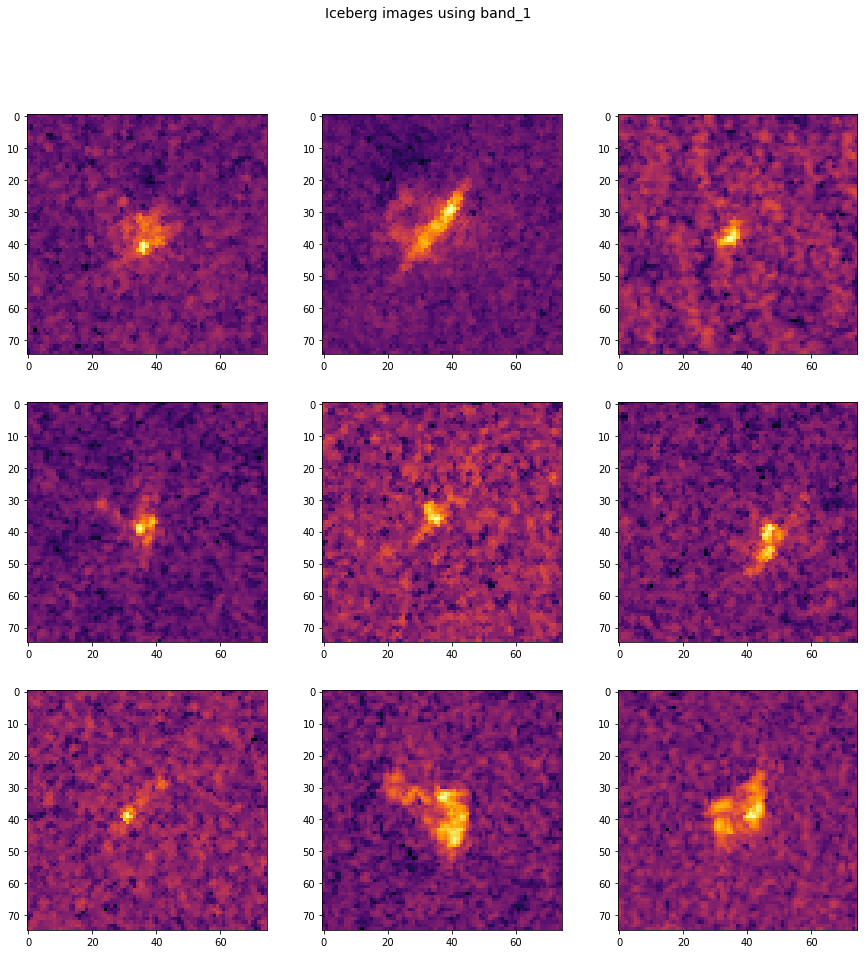

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Plot band_1
fig = plt.figure(1,figsize=(15,15))
fig.suptitle('Iceberg images using band_1', fontsize=14)

idx = 0
for index, row in icebergs.iterrows():
    sp = fig.add_subplot(3,3,idx+1)
    arr = np.reshape(np.array(row['band_1']),(75,75))
    sp.imshow(arr,cmap='inferno')
    idx+=1
        
plt.show()

  
    
#### **band_2:** Plotting 9 random raw images of iceberg using **band_2**

In [16]:
# Plot band_2
fig = plt.figure(1,figsize=(15,15))
fig.suptitle('Iceberg images using band_2', fontsize=14)

idx = 0
for index, row in icebergs.iterrows():
    sp = fig.add_subplot(3,3,idx+1)
    arr = np.reshape(np.array(row['band_2']),(75,75))
    sp.imshow(arr,cmap='inferno')
    idx+=1
        
plt.show()

#### Plot images of non-icebergs
**band_1:** Plotting 9 random raw images of non-icebergs using band_1

In [17]:
# Plot band_1
fig = plt.figure(1,figsize=(15,15))
fig.suptitle('non-icebergs images using band_1', fontsize=14)

idx = 0
for index, row in non_icebergs.iterrows():
    sp = fig.add_subplot(3,3,idx+1)
    arr = np.reshape(np.array(row['band_1']),(75,75))
    sp.imshow(arr,cmap='inferno')
    idx+=1
        
plt.show()

**band_2:** Plotting 9 random raw images of non-icebergs using band_2

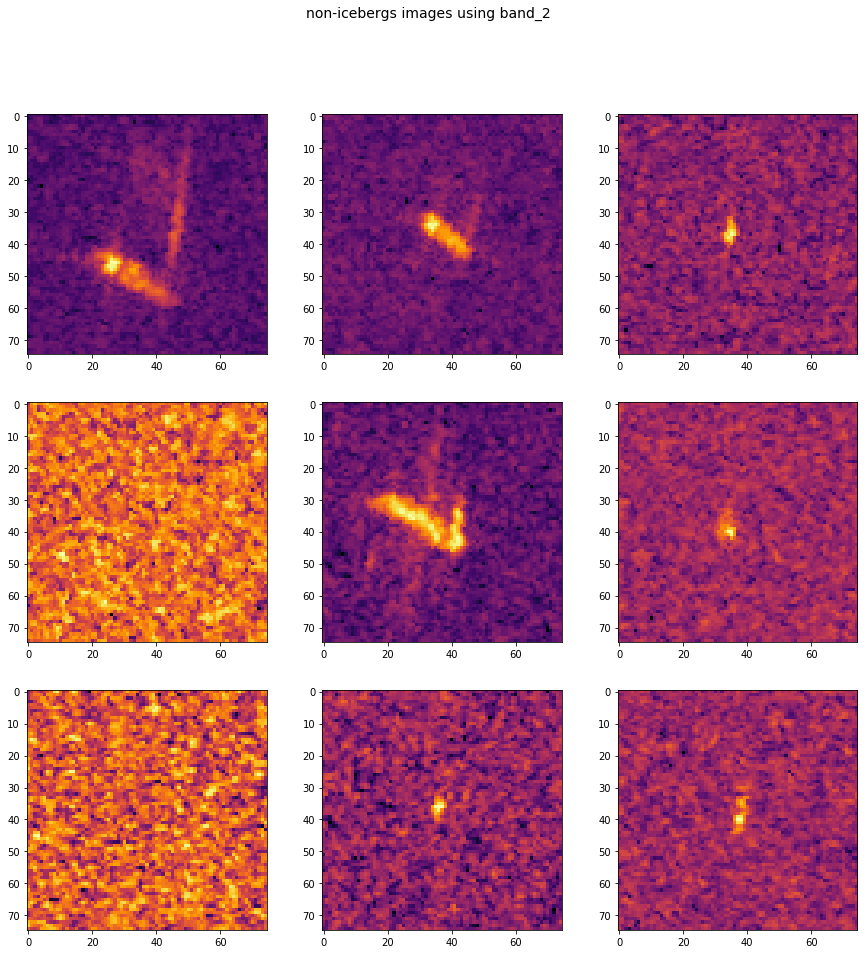

In [18]:
# Plot band_2
fig = plt.figure(1,figsize=(15,15))
fig.suptitle('non-icebergs images using band_2', fontsize=14)

idx = 0
for index, row in non_icebergs.iterrows():
    sp = fig.add_subplot(3,3,idx+1)
    arr = np.reshape(np.array(row['band_2']),(75,75))
    sp.imshow(arr,cmap='inferno')
    idx+=1
        
plt.show()

#### Combine band_1 and band_2
Now, if we simply add band_1, band_2 and then plot them for both icebergs and non-icebergs with the same random data.

In [19]:
# Plot both band_1 and band_2
fig = plt.figure(1,figsize=(15,15))
fig.suptitle('Iceberg images using bad_1, band_2', fontsize=14)

idx = 0
for index, row in icebergs.iterrows():
    sp = fig.add_subplot(3,3,idx+1)
    arr = np.reshape(np.array( np.add(row['band_2'],row['band_1'])),(75,75))
    sp.imshow(arr,cmap='inferno')
    idx+=1
        
plt.show()

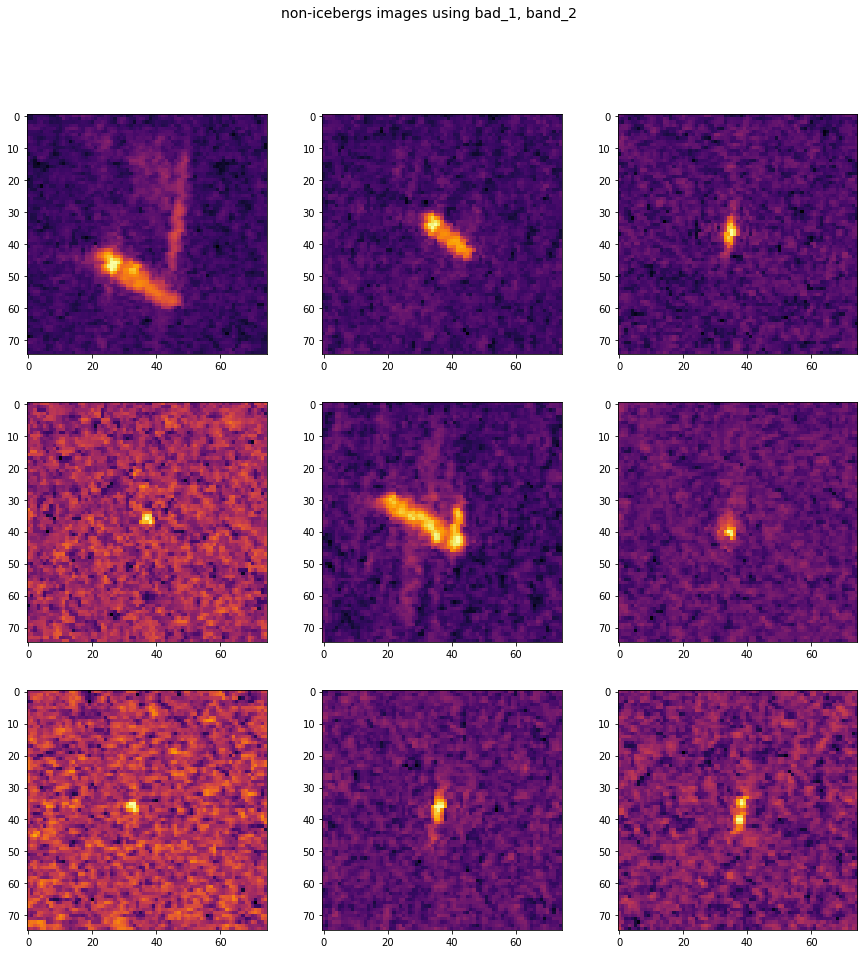

In [20]:
# Plot both band_1 and band_2
fig = plt.figure(1,figsize=(15,15))
fig.suptitle('non-icebergs images using bad_1, band_2', fontsize=14)

idx = 0
for index, row in non_icebergs.iterrows():
    sp = fig.add_subplot(3,3,idx+1)
    arr = np.reshape(np.array( np.add(row['band_2'],row['band_1'])),(75,75))
    sp.imshow(arr,cmap='inferno')
    idx+=1
        
plt.show()

Here we can se that, band_1 does better identifying the object from the background. band_2 seems to lack in some cases. If we add both band_1 and band-2 we get decent image compared to band_2.

## Benchmark
Create a one layer CNN for benchmark model.

In [21]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()

#Conv Layer 1
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(75, 75, 3)))

# Flatten
model.add(Flatten())

#Sigmoid Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
flatten_1 (Flatten)          (None, 341056)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 341057    
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 342,849
Trainable params: 342,849
Non-trainable params: 0
_________________________________________________________________


In [22]:
mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])

In [23]:
from sklearn.model_selection import train_test_split


#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_2"]])
X = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

y_target = df_train['is_iceberg']

X_train, X_valid, y_train, y_valid = train_test_split(X, y_target, random_state=1, train_size=0.75)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2022: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [24]:
from keras.callbacks import ModelCheckpoint  

epochs = 10

checkpointer = ModelCheckpoint(filepath='.weights.best.benchmark.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train,
          batch_size=24,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=[checkpointer])

Train on 1203 samples, validate on 401 samples
Epoch 1/10
1203/1203 [==============================] - 6s 5ms/step - loss: 8.4087 - acc: 0.4663 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00001: val_loss improved from inf to 8.46815, saving model to .weights.best.benchmark.hdf5
Epoch 2/10
1203/1203 [==============================] - 6s 5ms/step - loss: 8.4549 - acc: 0.4697 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00002: val_loss did not improve from 8.46815
Epoch 3/10
1203/1203 [==============================] - 6s 5ms/step - loss: 8.4549 - acc: 0.4697 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00003: val_loss did not improve from 8.46815
Epoch 4/10
1203/1203 [==============================] - 6s 5ms/step - loss: 8.4549 - acc: 0.4697 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00004: val_loss did not improve from 8.46815
Epoch 5/10
1203/1203 [==============================] - 6s 5ms/step - loss: 8.4549 - acc: 0.4697 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00005: val_loss did no

## Implementation
### Create a CNN to classify iceberg
In this section we will be creating a CNN from scratch to classify iceberg. 

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()

#Conv Layer 1
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(75, 75, 3)))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Dropout(0.2))

#Conv Layer 2
model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(75, 75, 3)))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Dropout(0.2))

# Flatten
model.add(Flatten())

# Dense Layer 1
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

#Sigmoid Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
__________

In [26]:
mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])

In [27]:
from sklearn.model_selection import train_test_split


#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_2"]])
X = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

y_target = df_train['is_iceberg']

X_train, X_valid, y_train, y_valid = train_test_split(X, y_target, random_state=1, train_size=0.75)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2022: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [28]:
from keras.callbacks import ModelCheckpoint  

epochs = 10

checkpointer = ModelCheckpoint(filepath='.weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train,
          batch_size=24,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=[checkpointer])

Train on 1203 samples, validate on 401 samples
Epoch 1/10
1203/1203 [==============================] - 35s 29ms/step - loss: 8.3414 - acc: 0.4730 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00001: val_loss improved from inf to 8.46815, saving model to .weights.best.from_scratch.hdf5
Epoch 2/10
1203/1203 [==============================] - 32s 27ms/step - loss: 8.4549 - acc: 0.4697 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00002: val_loss did not improve from 8.46815
Epoch 3/10
1203/1203 [==============================] - 32s 27ms/step - loss: 8.4549 - acc: 0.4697 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00003: val_loss did not improve from 8.46815
Epoch 4/10
1203/1203 [==============================] - 32s 27ms/step - loss: 8.4549 - acc: 0.4697 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00004: val_loss did not improve from 8.46815
Epoch 5/10
1203/1203 [==============================] - 32s 27ms/step - loss: 8.4549 - acc: 0.4697 - val_loss: 8.4681 - val_acc: 0.4688

Epoch 00005: va

### Score
As we do not have the test data labeled and in order to get the score of the test data we have to submit it in the Kaggle competition, we will take the validation accuracy(val_acc) as our score in this case. 

The loss score was the lowest at 8.4681 and the val_acc was 0.4688. So, this model gives us 46.88% accuracy. 

## Improvement
In order to imporve the CNN to achieve a better accuracy we are going to increase the layers. We will be adding 2 more Convolutional Layers and 1 more Dense Layer. Also we will increase epoch from 10 to 50. 

In [29]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
### Defining my own CNN architecture.
model.add(BatchNormalization(input_shape=(75, 75, 3)))
model.add(Conv2D(filters=16, kernel_size=3, padding="same", kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, padding="same", kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, padding="same", kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, padding="same", kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, padding="same", kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Flatten
model.add(Flatten())

# Dense Layer 1
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

# Dense Layer 2
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

#Sigmoid Layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 37, 16)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 37, 37, 16)        64        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 32)        0         
__________

In [30]:
mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])

In [31]:
from sklearn.model_selection import train_test_split


#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_train["band_2"]])
X = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

y_target = df_train['is_iceberg']

X_train, X_valid, y_train, y_valid = train_test_split(X, y_target, random_state=1, train_size=0.75)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2022: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [32]:
from keras.callbacks import ModelCheckpoint  

epochs = 50

checkpointer = ModelCheckpoint(filepath='.weights.best.improved.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train,
          batch_size=24,
          epochs=epochs,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=[checkpointer])

Train on 1203 samples, validate on 401 samples
Epoch 1/50
1203/1203 [==============================] - 19s 16ms/step - loss: 0.6623 - acc: 0.6417 - val_loss: 0.8560 - val_acc: 0.5387

Epoch 00001: val_loss improved from inf to 0.85595, saving model to .weights.best.improved.hdf5
Epoch 2/50
1203/1203 [==============================] - 17s 14ms/step - loss: 0.5587 - acc: 0.7190 - val_loss: 0.7052 - val_acc: 0.6509

Epoch 00002: val_loss improved from 0.85595 to 0.70522, saving model to .weights.best.improved.hdf5
Epoch 3/50
1203/1203 [==============================] - 17s 14ms/step - loss: 0.4696 - acc: 0.7490 - val_loss: 0.6817 - val_acc: 0.7007

Epoch 00003: val_loss improved from 0.70522 to 0.68165, saving model to .weights.best.improved.hdf5
Epoch 4/50
1203/1203 [==============================] - 17s 14ms/step - loss: 0.4324 - acc: 0.7922 - val_loss: 0.7535 - val_acc: 0.5960

Epoch 00004: val_loss did not improve from 0.68165
Epoch 5/50
1203/1203 [==============================] - 17


Epoch 00041: val_loss did not improve from 0.21628
Epoch 42/50
1203/1203 [==============================] - 17s 14ms/step - loss: 0.1669 - acc: 0.9343 - val_loss: 0.2967 - val_acc: 0.8803

Epoch 00042: val_loss did not improve from 0.21628
Epoch 43/50
1203/1203 [==============================] - 18s 15ms/step - loss: 0.1656 - acc: 0.9227 - val_loss: 0.2767 - val_acc: 0.8903

Epoch 00043: val_loss did not improve from 0.21628
Epoch 44/50
1203/1203 [==============================] - 17s 15ms/step - loss: 0.1359 - acc: 0.9401 - val_loss: 0.3326 - val_acc: 0.8828

Epoch 00044: val_loss did not improve from 0.21628
Epoch 45/50
1203/1203 [==============================] - 18s 15ms/step - loss: 0.1348 - acc: 0.9451 - val_loss: 0.3299 - val_acc: 0.8953

Epoch 00045: val_loss did not improve from 0.21628
Epoch 46/50
1203/1203 [==============================] - 18s 15ms/step - loss: 0.1501 - acc: 0.9435 - val_loss: 0.2821 - val_acc: 0.8878

Epoch 00046: val_loss did not improve from 0.21628
Epo

### Final Score
As we do not have the test data labeled and in order to get the score of the test data we have to submit it in the Kaggle competition, we will take the validation accuracy(val_acc) as our score in this case. 

The val_loss score was the lowest at 0.6208 and the val_acc was 0.8579. So, this model gives us 85.79% Accuracy. 
This seems like a very good modelas we are getting 85.79% correct results.

In [33]:
test_images = df_test.sample(n=1,random_state=666)

In [34]:
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in df_test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test=model.predict_proba(X_test)

### Plot some random images from test dataset with corresponding prediction value

In [35]:
# Plot random test data
samplt_test = df_test.sample(n=9,random_state=333)

fig = plt.figure(1,figsize=(15,15))
fig.suptitle('random images from test dataset with corresponding prediction value', fontsize=14)

idx = 0
for index, row in samplt_test.iterrows():
    sp = fig.add_subplot(3,3,idx+1)
    sp.title.set_text(predicted_test[index])
    arr = np.reshape(np.array( np.add(row['band_2'],row['band_1'])),(75,75))
    sp.imshow(arr,cmap='inferno')
    idx+=1
        
plt.show()

### How the model performs for change of data

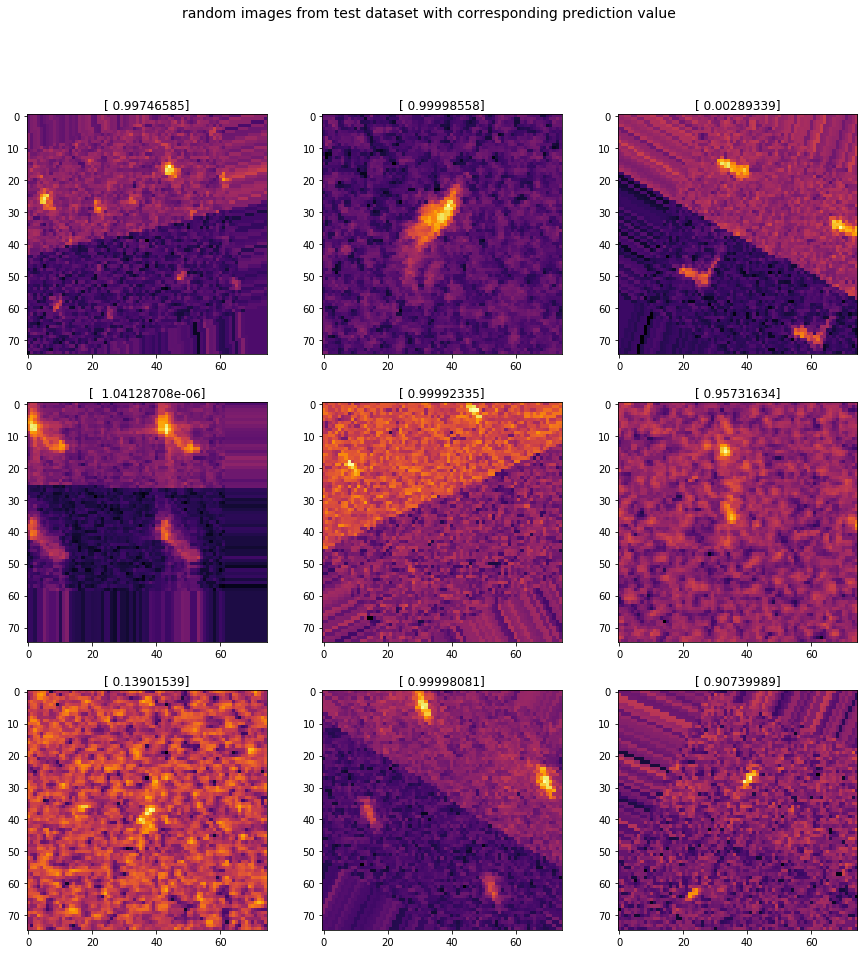

In [36]:
sample_images = df_test.sample(n=9,random_state=355)

X_band_test_1_sample=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in sample_images["band_1"]])
X_band_test_2_sample=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in sample_images["band_2"]])
X_test_sample = np.concatenate([X_band_test_1_sample[:, :, :, np.newaxis]
                          , X_band_test_2_sample[:, :, :, np.newaxis]
                         , ((X_band_test_1_sample+X_band_test_2_sample)/2)[:, :, :, np.newaxis]], axis=-1)
predicted_test_2 =model.predict_proba(X_test_sample)


fig = plt.figure(1,figsize=(15,15))
fig.suptitle('random images from test dataset with corresponding prediction value', fontsize=14)

idx = 0
for index, row in sample_images.iterrows():
    sp = fig.add_subplot(3,3,idx+1)
    sp.title.set_text(predicted_test[index])
    arr = np.reshape(np.array( np.add(row['band_2'],row['band_1'])),(75,75))
    sp.imshow(arr,cmap='inferno')
    idx+=1
        
plt.show()


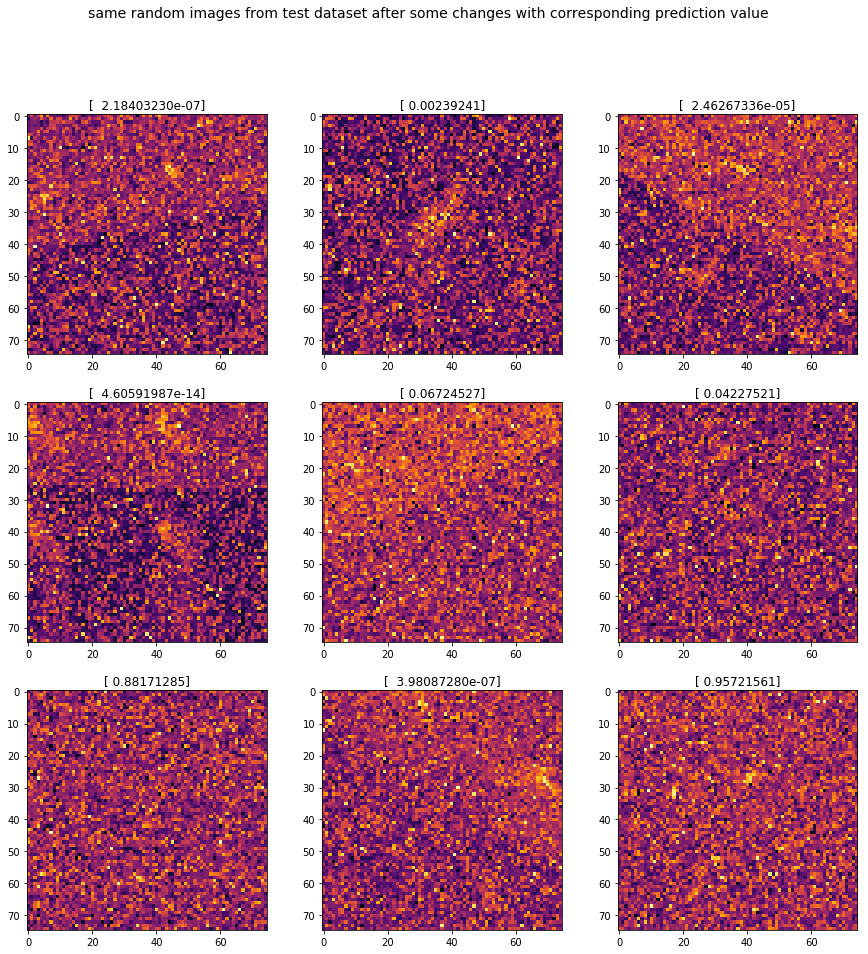

In [37]:
import random

all_predictions = []
all_predictions.append(predicted_test_2.flatten())

def change_and_plot(number):
    sample_images_2 = df_test.sample(n=9,random_state=355)

    number_of_values_to_replace = number;

    for index, row in sample_images_2.iterrows():
        max_b1 = int(max(sample_images_2['band_1'][index]))
        min_b1 = int(min(sample_images_2['band_1'][index]))
        
        max_b2 = int(max(sample_images_2['band_1'][index]))
        min_b2 = int(min(sample_images_2['band_1'][index]))
        
        for j in range(number_of_values_to_replace):
            sample_images_2['band_1'][index][random.randint(0,5624)] = random.randint(min_b1,max_b1)
            sample_images_2['band_2'][index][random.randint(0,5624)] = random.randint(min_b2,max_b2)



    X_band_test_1_sample_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in sample_images_2["band_1"]])
    X_band_test_2_sample_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in sample_images_2["band_2"]])
    X_test_sample_2 = np.concatenate([X_band_test_1_sample_2[:, :, :, np.newaxis]
                              , X_band_test_2_sample_2[:, :, :, np.newaxis]
                             , ((X_band_test_1_sample_2+X_band_test_2_sample_2)/2)[:, :, :, np.newaxis]], axis=-1)
    predicted_test_2_2 =model.predict_proba(X_test_sample_2)

    all_predictions.append(predicted_test_2_2.flatten())
    
    fig = plt.figure(1,figsize=(15,15))
    fig.suptitle('same random images from test dataset after some changes with corresponding prediction value', fontsize=14)

    idx = 0
    for index, row in sample_images_2.iterrows():
        sp = fig.add_subplot(3,3,idx+1)
        sp.title.set_text(predicted_test_2_2[idx])
        arr = np.reshape(np.array( np.add(row['band_2'],row['band_1'])),(75,75))
        sp.imshow(arr,cmap='inferno')
        idx+=1

    plt.show()
    
change_and_plot(50)
change_and_plot(500)
change_and_plot(1000)
change_and_plot(2000)


# Let's have a look at the label distribution

([<matplotlib.patches.Wedge at 0x7f9472166eb8>,
 [Text(0.105407,1.09494,'Iceberg'), Text(-0.107323,-1.11485,'Non-iceberg')],
 [Text(0.0574945,0.597239,'47%'), Text(-0.0594109,-0.617147,'53%')])

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning:

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans



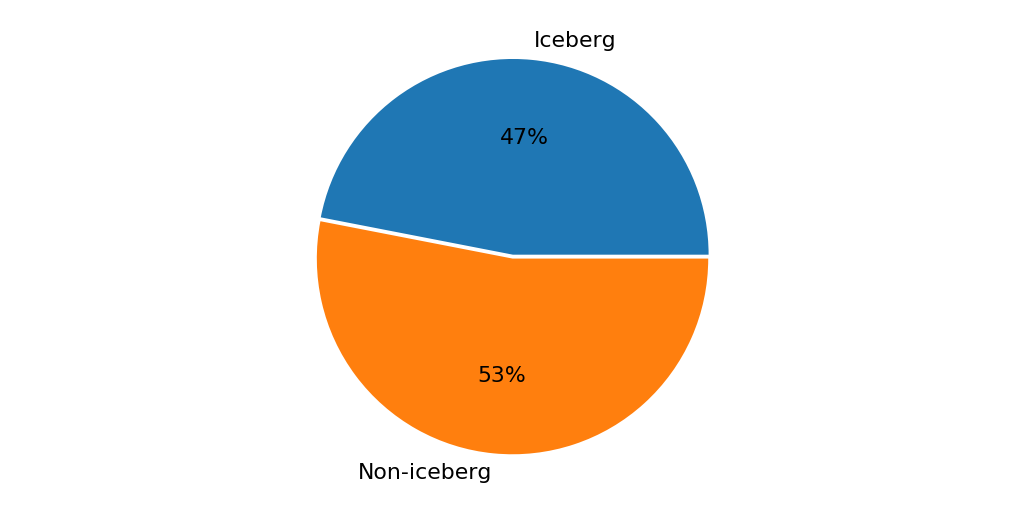

In [39]:
# from matplotlib.gridspec import GridSpec
# the_grid = GridSpec(1, 1)
# plt.subplot(the_grid[0, 0], aspect=1)

labels = ['Iceberg', 'Non-iceberg']
explode = (0, 0.02)
iceberg_count = len(df_train[df_train.is_iceberg==1])
non_iceberg_count = len(df_train[df_train.is_iceberg==0])
total_count = iceberg_count + non_iceberg_count
perc = [ (iceberg_count/total_count), (non_iceberg_count/total_count) ]
plt.axis('equal')
plt.pie(perc, explode=explode, labels=labels, autopct='%.00f%%')